<a href="https://colab.research.google.com/github/bodong408/Machine-Learning/blob/main/San_Jose_Battle_of_the_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Battle of the Neighborhoods**

**Finding the best Neighbourhood in San Jose, CA using Data Science**

This project aims to utilize all Data Science Concepts learned in the IBM Data Science Professional Course. We define a Business Problem, the data that will be utilized and using that data, we are able to analyze it using Machine Learning tools. In this project, we will go through all the processes in a step by step manner from problem designing, data preparation to final analysis and finally will provide a conclusion that can be leveraged by the business stakeholders to make their decisions.

**Table of Contents**
1. Introduction
2. Target Audience
3. Data Overview
4. Methodology
5. Discussion
6. Conclusion

**1. Introduction:**

San Jose is a large city surrounded by rolling hills in Silicon Valley, a major technology hub in California's Bay Area. Architectural landmarks, from the 1883 Italianate-style Oddfellows building to Spanish Colonial Revival structures, make up the downtown historic district.

San José is the cultural, financial, and political center of Silicon Valley and the largest city in Northern California, by both population and area. San Jose is the county seat of Santa Clara County, the most affluent county in California and one of the most affluent counties in the United States. San Jose is notable as a center of innovation, for its affluence, Mediterranean climate, and extremely high cost of living. Its location within the booming high tech industry as a cultural, political, and economic center has earned the city the nickname "Capital of Silicon Valley".

San Jose is one of the wealthiest major cities in the United States and the world, and has the third-highest GDP per capita in the world (after Zürich, Switzerland and Oslo, Norway). The San Jose Metropolitan Area has the most millionaires and the most billionaires in the United States per capita. With a median home price of $1,085,000, San Jose has the most expensive housing market in the country and the fifth most expensive housing market in the world.

**2. Target Audience**

This project is aimed towards Entrepreneurs or Business owners who want to open a new Chinese Restaurant or grow their current business. The analysis will provide vital information that can be used by the target audience.

**3. Data Overview**

The data that will be required will be a combination of CSV files that have been prepared for the purposes of the analysis from multiple sources which will provide the list of neighbourhoods in San Jose (via Wikipedia), the Geographical location of the neighbourhoods (via Geocoder package) and Venue data via Foursquare. The Venue data will help find which neighbourhood is best suitable to open a Chinese restaurant.

**3.1 — Data acquisition:**

Source 1: San Jose Neighborhoods via Wikipedia

The city is generally divided into the following areas: 

1. Downtown San Jose, 
3. West San Jose, 
4. North San Jose, 
5. East San Jose, 
6. South San Jose. 

Many of these regions were originally unincorporated communities or separate municipalities that were later annexed by the city.

**Source 3: Venue Data using Foursquare**

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [32]:
df = pd.read_csv('https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&q=san+jose&timezone=America/Los_Angeles&lang=en&use_labels_for_header=true&csv_separator=,')
df.drop(df[df['State'] != 'CA'].index, inplace = True)

In [58]:
sj_city = 'San Jose, CA, USA'
geolocator = Nominatim(user_agent="explorer")
sj_location = geolocator.geocode(sj_city)
sj_latitude = sj_location.latitude
sj_longitude = sj_location.longitude


In [59]:
# create map of San Jose using latitude and longitude values
map = folium.Map(location=[sj_latitude, sj_longitude], zoom_start=10)

# add markers to map
for lat, lng, zipcode in zip(df['Latitude'], df['Longitude'], df['Zip']):
    label = zipcode
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

In [60]:
CLIENT_ID = 'S3DCBMSDPSFP4NKZQ5AATH0B3ARVGWWTK1EIUPIGVER1EMEE' # your Foursquare ID
CLIENT_SECRET = 'GYOJDQOCXILZDUAOJLLVNAVKURJDFJ3VW5OAGWLIXUBY51X3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: S3DCBMSDPSFP4NKZQ5AATH0B3ARVGWWTK1EIUPIGVER1EMEE
CLIENT_SECRET:GYOJDQOCXILZDUAOJLLVNAVKURJDFJ3VW5OAGWLIXUBY51X3


In [61]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [64]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'ZipCode Latitude', 
                  'ZipCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [65]:
names = df['Zip']
latitudes = df['Latitude']
longitudes = df['Longitude']
venues = getNearbyVenues(names, latitudes, longitudes)
venues.head()

95159
95190
95131
95160
95111
95103
95119
95128
95120
95130
95148
95114
95138
95136
95134
95139
95137
95132
95124
95194
95155
95108
95125
95141
95193
95196
95151
95133
95164
95172
95191
95157
95112
95156
95121
95142
95150
95110
95153
95152
95123
95170
95126
95116
95192
95106
95117
95118
95158
95129
95154
95115
95171
95161
95173
95109
95122
95101
95102
95113
95135
95127


,ZipCode,ZipCode Latitude,ZipCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,95159,37.189396,-121.705327,babystuffgifts,37.190322,-121.707380,Gift Shop
1,95190,37.189396,-121.705327,babystuffgifts,37.190322,-121.707380,Gift Shop
2,95131,37.386310,-121.889870,Wuji's Mala House,37.387405,-121.887652,Chinese Restaurant
3,95131,37.386310,-121.889870,GONG CHA (貢茶),37.387362,-121.887593,Bubble Tea Shop
4,95131,37.386310,-121.889870,Popbar,37.387156,-121.885284,Ice Cream Shop


In [66]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['ZipCode'] = venues['ZipCode'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,ZipCode,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beer Bar,Big Box Store,Board Shop,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Dessert Shop,Discount Store,Event Space,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food Court,Food Truck,Football Stadium,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,High School,Hockey Arena,Home Service,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Moving Target,Music Venue,Nail Salon,North Indian Restaurant,Paintball Field,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Record Shop,Rest Area,Restaurant,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shop & Service,Smoke Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Sushi Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,95159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,95190,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,95131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,95131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,95131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
grouped = onehot.groupby('ZipCode').mean().reset_index()
grouped.head()

,ZipCode,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beer Bar,Big Box Store,Board Shop,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Dessert Shop,Discount Store,Event Space,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food Court,Food Truck,Football Stadium,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,High School,Hockey Arena,Home Service,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Moving Target,Music Venue,Nail Salon,North Indian Restaurant,Paintball Field,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Record Shop,Rest Area,Restaurant,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shop & Service,Smoke Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Sushi Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,95101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,95102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,95103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,95106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [69]:
num_top_venues = 5

for zipcode in grouped['ZipCode']:
    print("----" + str(zipcode) + "----")
    temp = grouped[grouped['ZipCode'] == zipcode].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----95101----
                   venue  freq
0              Gift Shop   1.0
1      Afghan Restaurant   0.0
2  Performing Arts Venue   0.0
3            Music Venue   0.0
4             Nail Salon   0.0


----95102----
                   venue  freq
0              Gift Shop   1.0
1      Afghan Restaurant   0.0
2  Performing Arts Venue   0.0
3            Music Venue   0.0
4             Nail Salon   0.0


----95103----
                   venue  freq
0              Gift Shop   1.0
1      Afghan Restaurant   0.0
2  Performing Arts Venue   0.0
3            Music Venue   0.0
4             Nail Salon   0.0


----95106----
                   venue  freq
0              Gift Shop   1.0
1      Afghan Restaurant   0.0
2  Performing Arts Venue   0.0
3            Music Venue   0.0
4             Nail Salon   0.0


----95108----
                   venue  freq
0              Gift Shop   1.0
1      Afghan Restaurant   0.0
2  Performing Arts Venue   0.0
3            Music Venue   0.0
4             Nail Salo

In [71]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [72]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['ZipCode'] = grouped['ZipCode']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,95101,Gift Shop,Yoga Studio,Dessert Shop,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Event Space,Discount Store,Dance Studio,Food Truck
1,95102,Gift Shop,Yoga Studio,Dessert Shop,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Event Space,Discount Store,Dance Studio,Food Truck
2,95103,Gift Shop,Yoga Studio,Dessert Shop,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Event Space,Discount Store,Dance Studio,Food Truck
3,95106,Gift Shop,Yoga Studio,Dessert Shop,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Event Space,Discount Store,Dance Studio,Food Truck
4,95108,Gift Shop,Yoga Studio,Dessert Shop,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Event Space,Discount Store,Dance Studio,Food Truck


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f98bd6c2f60>,
                 k=None, metric=None, model=None, timings=True)

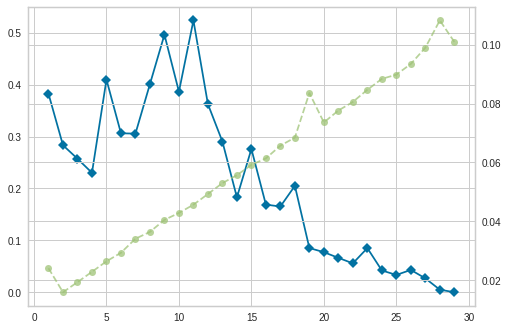

In [81]:
from yellowbrick.cluster import KElbowVisualizer

grouped_clustering = grouped.drop('ZipCode', 1)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 30))
visualizer.fit(grouped_clustering)


In [80]:
grouped_clustering.head()

,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beer Bar,Big Box Store,Board Shop,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Dessert Shop,Discount Store,Event Space,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food Court,Food Truck,Football Stadium,Fried Chicken Joint,Frozen Yogurt Shop,Garden,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,High School,Hockey Arena,Home Service,Hookah Bar,Hotel,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Moving Target,Music Venue,Nail Salon,North Indian Restaurant,Paintball Field,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Record Shop,Rest Area,Restaurant,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shop & Service,Smoke Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Steakhouse,Sushi Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0